# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.7262

947/947 [==============================] - 5783s 6s/step - loss: 0.8222 - accuracy: 0.7262 - val_loss: 0.8421 - val_accuracy: 0.7202
Epoch 2/200
947/947 [==============================] - 4964s 5s/step - loss: 0.7123 - accuracy: 0.7569 - val_loss: 1.0989 - val_accuracy: 0.7072
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.7747

947/947 [==============================] - 5408s 6s/step - loss: 0.6548 - accuracy: 0.7747 - val_loss: 0.6929 - val_accuracy: 0.7648
Epoch 4/200
947/947 [==============================] - 4975s 5s/step - loss: 0.6131 - accuracy: 0.7864 - val_loss: 0.7372 - val_accuracy: 0.7526
Epoch 5/200
947/947 [==============================] - 4977s 5s/step - loss: 0.5862 - accuracy: 0.7944 - val_loss: 0.8838 - val_accuracy: 0.7566
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.8020

947/947 [==============================] - 5362s 6s/step - loss: 0.5595 - accuracy: 0.8020 - val_loss: 0.6379 - val_accuracy: 0.7777
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.8079

947/947 [==============================] - 5362s 6s/step - loss: 0.5444 - accuracy: 0.8079 - val_loss: 0.6061 - val_accuracy: 0.7962
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.8182

947/947 [==============================] - 5368s 6s/step - loss: 0.5150 - accuracy: 0.8182 - val_loss: 0.5472 - val_accuracy: 0.8081
Epoch 9/200
947/947 [==============================] - 4987s 5s/step - loss: 0.5033 - accuracy: 0.8207 - val_loss: 0.6006 - val_accuracy: 0.7904
Epoch 10/200
947/947 [==============================] - 4978s 5s/step - loss: 0.4829 - accuracy: 0.8289 - val_loss: 0.6298 - val_accuracy: 0.7994
Epoch 11/200
947/947 [==============================] - 4981s 5s/step - loss: 0.4664 - accuracy: 0.8328 - val_loss: 0.5566 - val_accuracy: 0.8065
Epoch 12/200
947/947 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8409

947/947 [==============================] - 5373s 6s/step - loss: 0.4481 - accuracy: 0.8409 - val_loss: 0.5192 - val_accuracy: 0.8150
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8438

947/947 [==============================] - 5363s 6s/step - loss: 0.4338 - accuracy: 0.8438 - val_loss: 0.5055 - val_accuracy: 0.8214
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4267 - accuracy: 0.8457

947/947 [==============================] - 5363s 6s/step - loss: 0.4267 - accuracy: 0.8457 - val_loss: 0.4859 - val_accuracy: 0.8274
Epoch 15/200
947/947 [==============================] - 4982s 5s/step - loss: 0.4069 - accuracy: 0.8549 - val_loss: 0.5276 - val_accuracy: 0.8152
Epoch 16/200
947/947 [==============================] - 4984s 5s/step - loss: 0.3909 - accuracy: 0.8594 - val_loss: 0.5166 - val_accuracy: 0.8118
Epoch 17/200
947/947 [==============================] - 4986s 5s/step - loss: 0.3808 - accuracy: 0.8635 - val_loss: 0.6732 - val_accuracy: 0.7757
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.8661

947/947 [==============================] - 5375s 6s/step - loss: 0.3684 - accuracy: 0.8661 - val_loss: 0.4792 - val_accuracy: 0.8352
Epoch 19/200
947/947 [==============================] - 4985s 5s/step - loss: 0.3516 - accuracy: 0.8740 - val_loss: 0.5979 - val_accuracy: 0.8103
Epoch 20/200
947/947 [==============================] - 4986s 5s/step - loss: 0.3407 - accuracy: 0.8756 - val_loss: 0.4876 - val_accuracy: 0.8385
Epoch 21/200
947/947 [==============================] - 4986s 5s/step - loss: 0.3253 - accuracy: 0.8827 - val_loss: 0.4859 - val_accuracy: 0.8361
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8842

947/947 [==============================] - 5391s 6s/step - loss: 0.3201 - accuracy: 0.8842 - val_loss: 0.4689 - val_accuracy: 0.8390
Epoch 23/200
947/947 [==============================] - 4982s 5s/step - loss: 0.3051 - accuracy: 0.8876 - val_loss: 0.5122 - val_accuracy: 0.8287
Epoch 24/200
947/947 [==============================] - 4981s 5s/step - loss: 0.2931 - accuracy: 0.8909 - val_loss: 0.5127 - val_accuracy: 0.8295
Epoch 25/200
947/947 [==============================] - 4983s 5s/step - loss: 0.2758 - accuracy: 0.8972 - val_loss: 0.5455 - val_accuracy: 0.8324
Epoch 26/200
947/947 [==============================] - 4979s 5s/step - loss: 0.2772 - accuracy: 0.8975 - val_loss: 0.5673 - val_accuracy: 0.8205
Epoch 27/200
947/947 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9030

947/947 [==============================] - 5363s 6s/step - loss: 0.2599 - accuracy: 0.9030 - val_loss: 0.4628 - val_accuracy: 0.8498
Epoch 28/200
947/947 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9073

947/947 [==============================] - 5366s 6s/step - loss: 0.2536 - accuracy: 0.9073 - val_loss: 0.4537 - val_accuracy: 0.8506
Epoch 29/200
947/947 [==============================] - 4986s 5s/step - loss: 0.2382 - accuracy: 0.9137 - val_loss: 0.6068 - val_accuracy: 0.8200
Epoch 30/200
947/947 [==============================] - 4985s 5s/step - loss: 0.2309 - accuracy: 0.9146 - val_loss: 0.4837 - val_accuracy: 0.8461
Epoch 31/200
947/947 [==============================] - 4971s 5s/step - loss: 0.2205 - accuracy: 0.9188 - val_loss: 0.5654 - val_accuracy: 0.8325
Epoch 32/200
947/947 [==============================] - 5046s 5s/step - loss: 0.2130 - accuracy: 0.9218 - val_loss: 0.4707 - val_accuracy: 0.8465
Epoch 33/200
947/947 [==============================] - 5008s 5s/step - loss: 0.2048 - accuracy: 0.9251 - val_loss: 0.5178 - val_accuracy: 0.8477
Epoch 34/200
947/947 [==============================] - 5035s 5s/step - loss: 0.1954 - accuracy: 0.9300 - val_loss: 0.5912 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 549s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.974858232146862,
 'basal cell carcinoma': 0.9883820600073124,
 'dermatofibroma': 0.956619583433086,
 'melanoma': 0.9422955445230389,
 'nevus': 0.9689826943014183,
 'pigmented benign keratosis': 0.9852787923058194,
 'seborrheic keratosis': 0.9599847547771252,
 'solar lentigo': 0.9768044605131333,
 'squamous cell carcinoma': 0.9707339084462006,
 'vascular lesion': 0.9997936352775062}

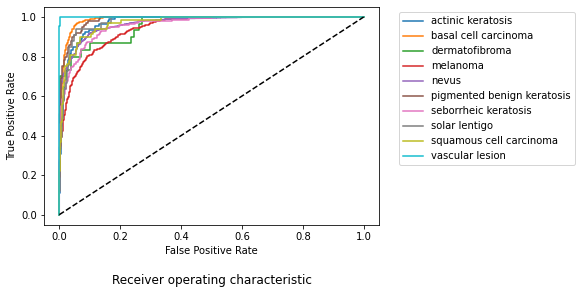

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

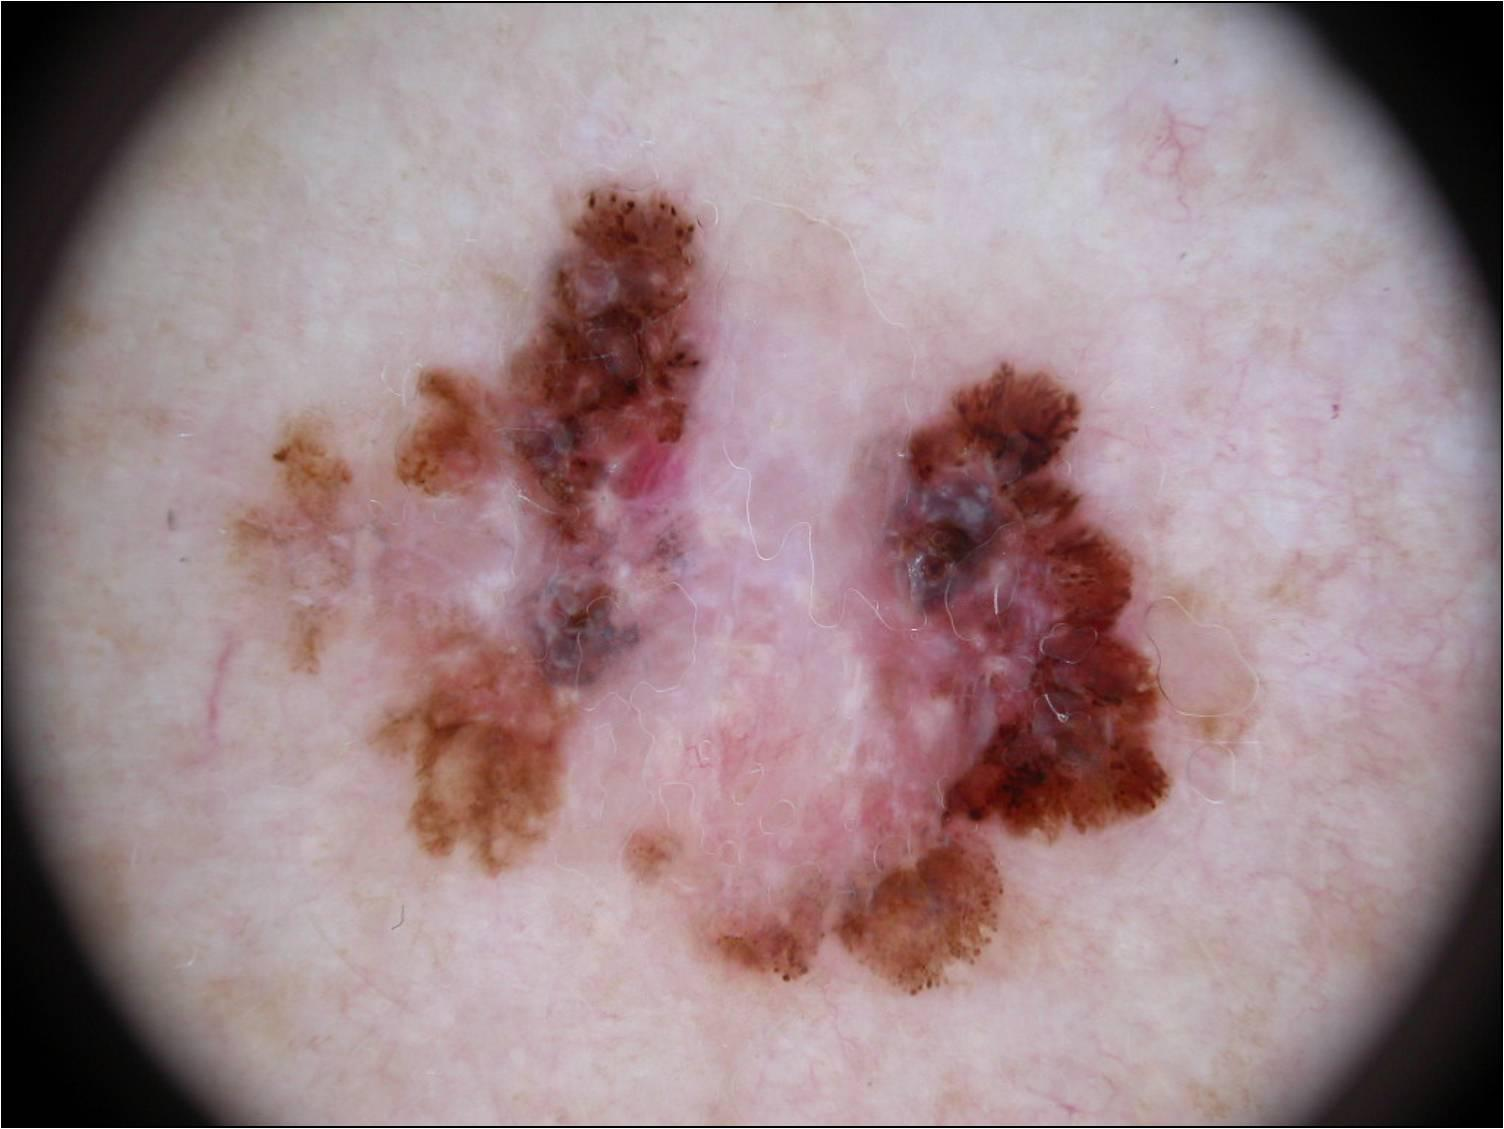

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'conv_7b')

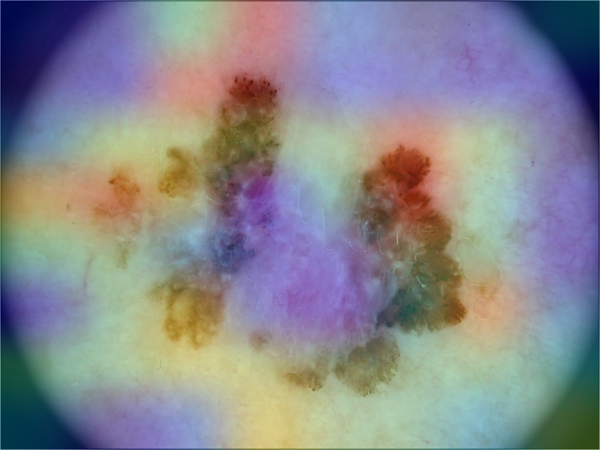

In [23]:
display_gradcam(melanoma_im_path, heatmap)